<h1>Topic Modeling — LDA Mallet</h1><a href="https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2">Tutorial Link</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

sns.set()

In [2]:
df=pd.read_excel("Data//articles.xlsx")
df.head()

,Title,Journal,Year,Abstract
0,Title 1,Journal 1,1988,PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMEN...
1,Title 2,Journal 2,1982,PURPOSE EMPLOYEE WELLNESS IS VITAL TO CREATING...
2,Title 3,Journal 3,1981,PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PL...
3,Title 4,Journal 3,1990,PURPOSE RESPONDING TO AN INCREASING CALL FOR A...
4,Title 5,Journal 3,1990,PURPOSE THE PURPOSE OF THIS STUDY IS TO IDENTI...


<h2> Explantory Analysis </h2>

In [3]:
# number of articles per Journal
df.Journal.value_counts()

Journal 15    972
Journal 8     899
Journal 2     616
Journal 10    327
Journal 4     317
Journal 5     310
Journal 1     306
Journal 3     298
Journal 6     293
Journal 12    292
Journal 14    275
Journal 13    274
Journal 11    274
Journal 7     274
Journal 9     273
Name: Journal, dtype: int64

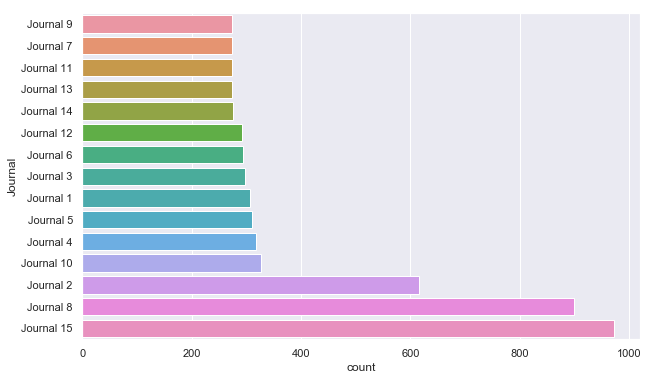

In [4]:
# order article counts
order = df.Journal.value_counts(ascending=True).index
plt.figure(figsize=(10,6))
sns.countplot(y='Journal', data=df, orient='h', order= order)

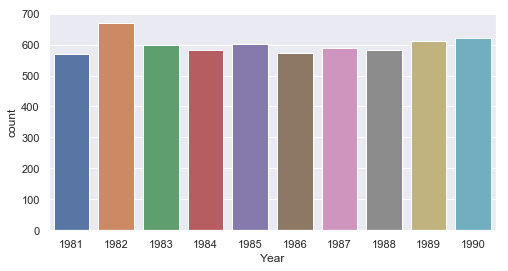

In [5]:
# number of yearly publications
plt.figure(figsize=(8,4))
sns.countplot(x='Year', data=df)

In [6]:
# number of articles per journal
pd.crosstab(df.Journal, df.Year)

Year,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
Journal,,,,,,,,,,
Journal 1,34,34,24,29,41,27,23,34,26,34
Journal 10,24,37,30,41,35,35,27,39,33,26
Journal 11,31,38,22,18,28,26,26,30,28,27
Journal 12,38,27,36,29,23,18,28,41,28,24
Journal 13,20,26,29,27,36,27,27,26,33,23
Journal 14,23,28,27,23,32,32,37,18,26,29
Journal 15,85,125,91,86,102,92,93,92,98,108
Journal 2,53,66,78,77,52,59,60,53,64,54
Journal 3,39,28,33,15,32,30,31,24,28,38


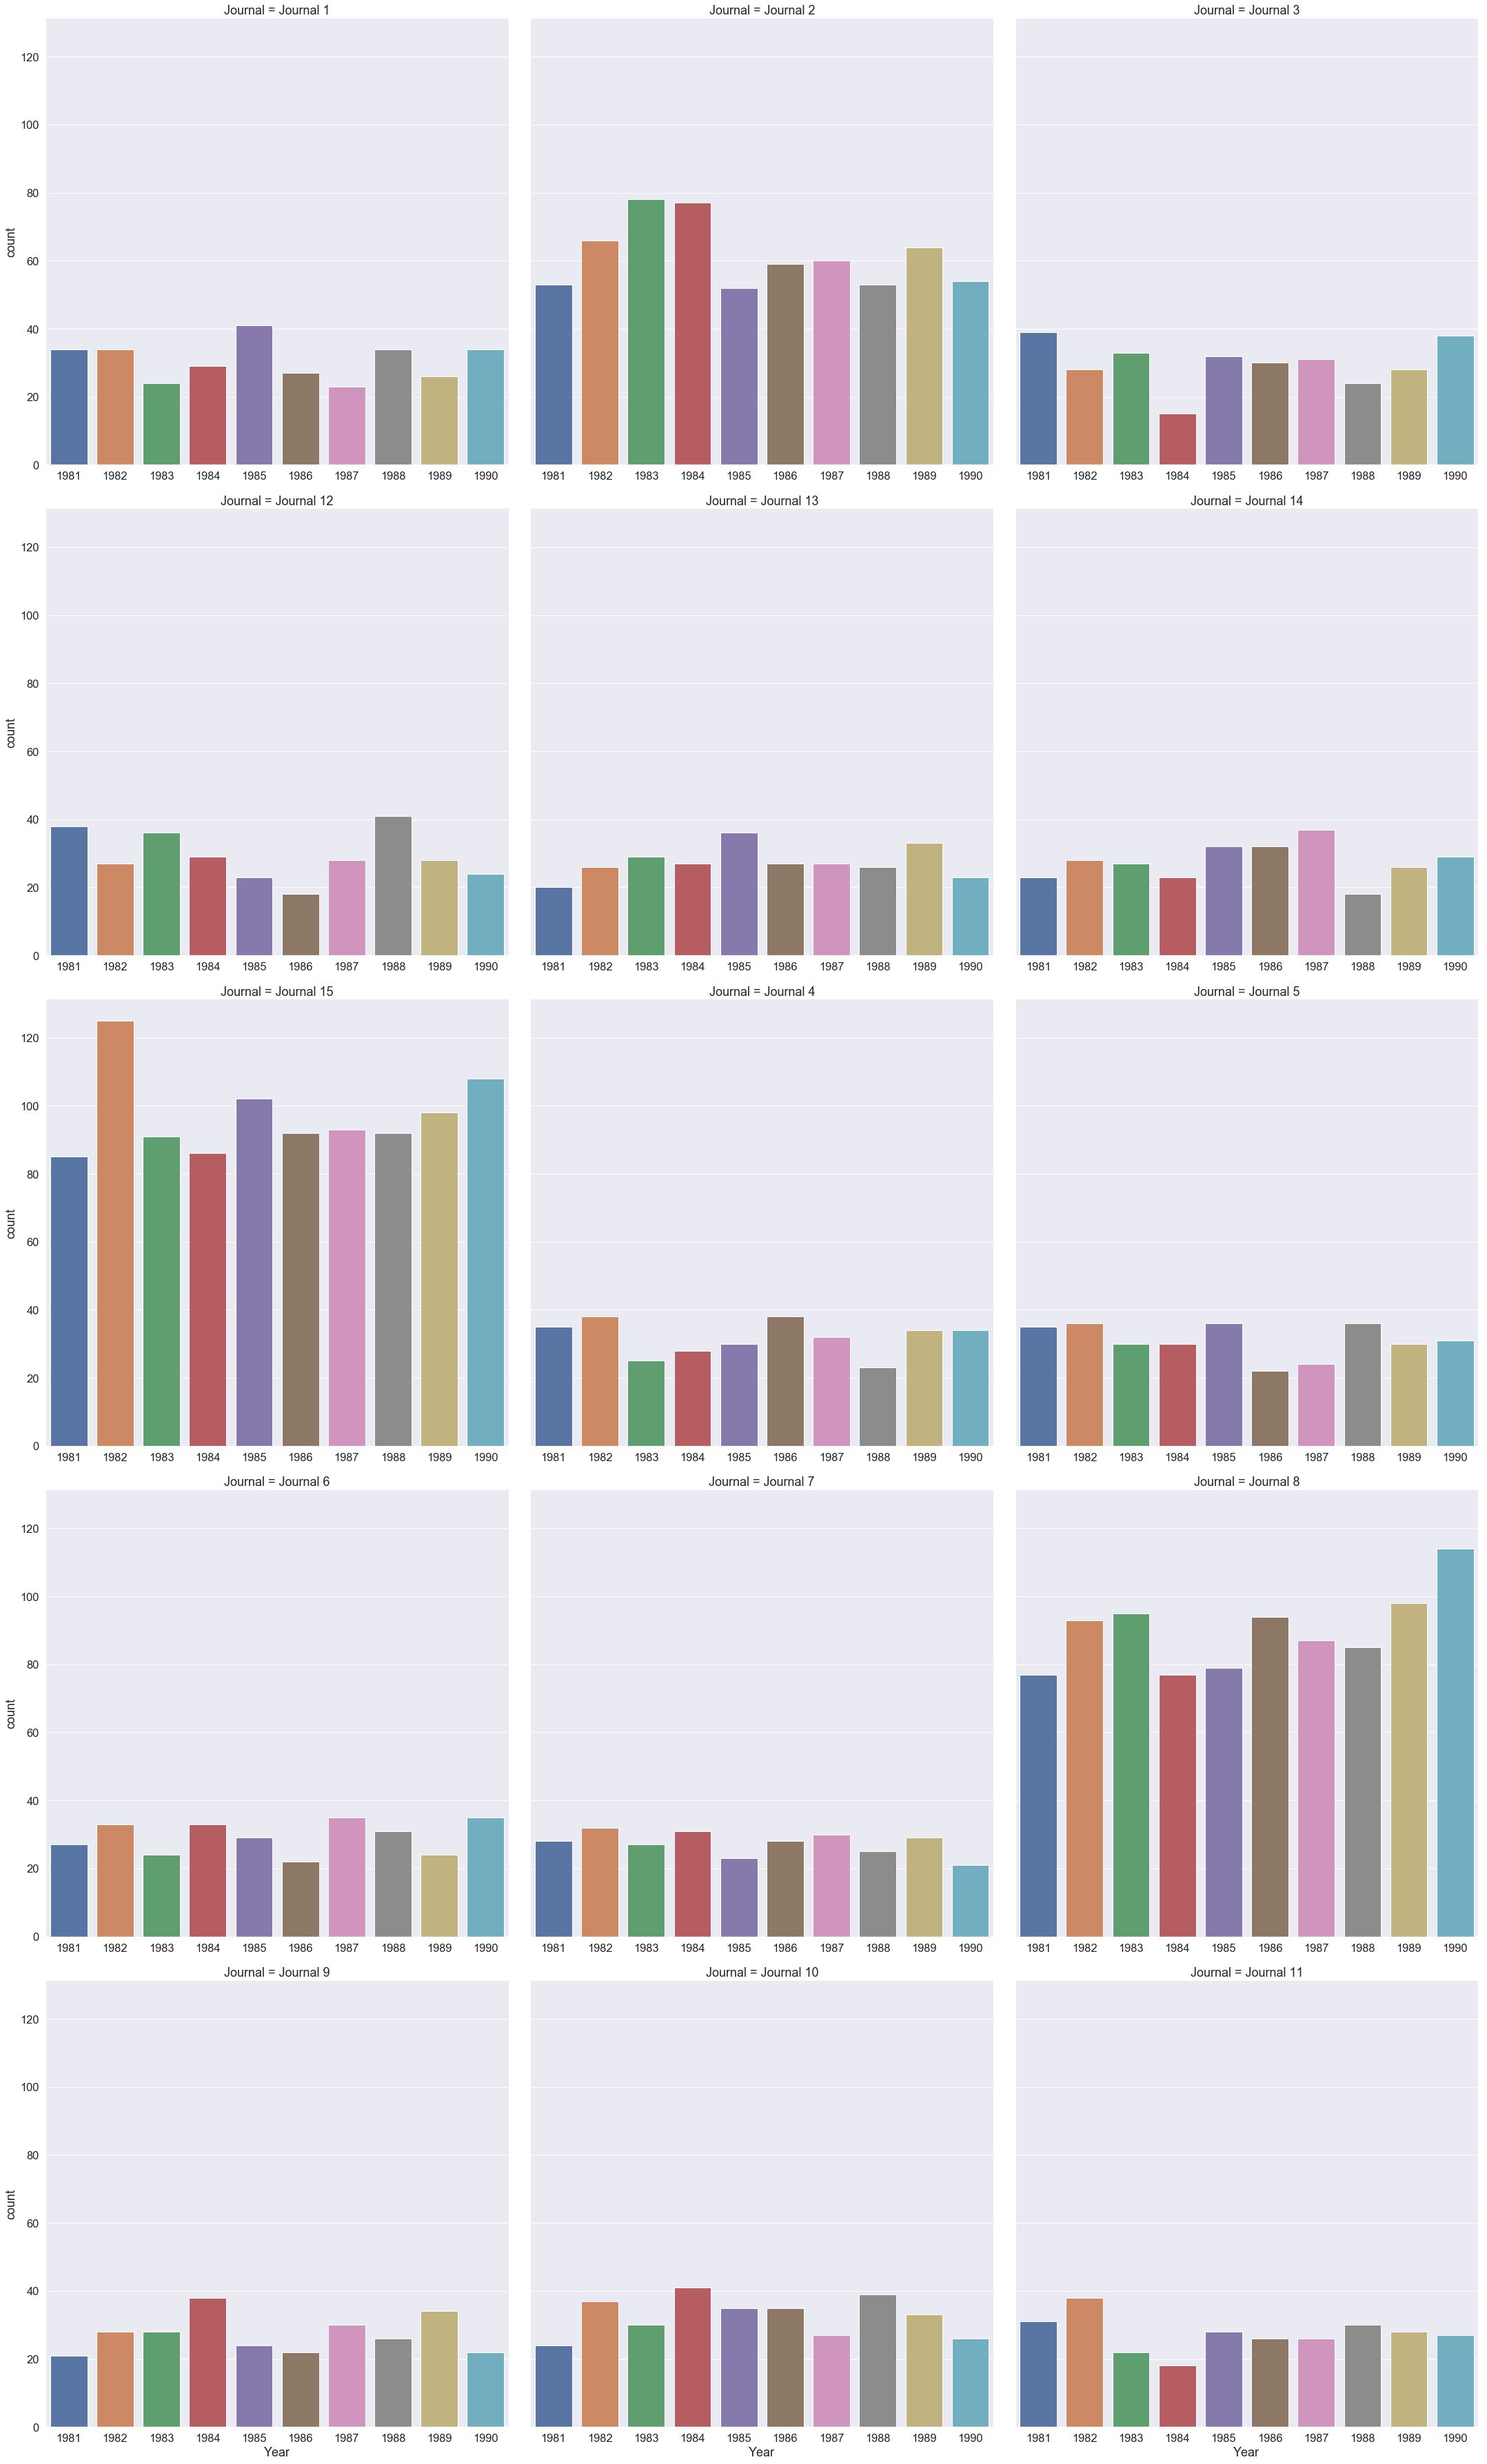

In [7]:
#subgraphs for number of articles for each year by journal
sns.set(font_scale=1.5)
sns.catplot(data=df, x='Year', col="Journal", col_wrap=3, sharex=False, height=10, kind='count')

<h2>Topic Modeling</h2>

In [8]:
import nltk
import pyLDAvis
import pyLDAvis.gensim

In [9]:
# import important densim libraries to build the model
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\sara\Anaconda3\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
C:\Users\sara\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [10]:
import spacy

C:\Users\sara\Anaconda3\lib\site-packages\jsonschema\compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping, Sequence  # noqa


<h4> Preprocessing</h4>
<p>Tokenization, Lemmatization, Ngrams, Speech of tag selection, </p>

In [11]:
# get a list of abstracts
data = list(df.Abstract)

In [12]:
# Build the bigram and trigrams
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# preprocessing function
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [14]:
data_ready = process_words(data)
# The output data_ready is a list containing list of strings for each document (abstract).

In [15]:
# create dictionary and get the length of vocabulary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary size: ', len(id2word))

Total Vocabulary size:  12845


In [16]:
# create corpus
# a list of lists containing tuples for each word id and its frequency.
corpus = [id2word.doc2bow(text) for text in data_ready]

In [17]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

C:\Users\sara\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


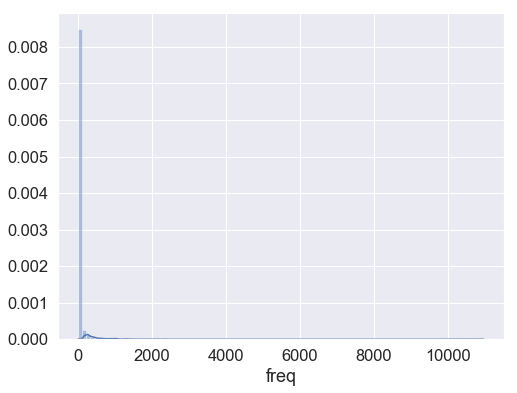

In [18]:
# a histogram that shows word frequencies to better understand the corpus
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100)

In [19]:
# Let’s see these top 10 high-frequency words in descending order.
dict_df.sort_values('freq', ascending = False).head(10)


,freq
tourism,10971
study,7072
tourist,5608
use,4567
destination,4029
research,3830
result,3257
experience,3086
service,2978
paper,2938


In [20]:
# filter out those words that have frequency over 1500.
extension = dict_df[dict_df.freq > 1500].index.tolist()

In [21]:
# we can add those words to stop words list and rerun the process_words function, since these words have an effect on forming bi-grams and tri-grams
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 12952


In [22]:
# Filter out words that occur less than 10 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 3182


In [23]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

<h3> Install Mallet Package </h3>

In [24]:
# http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [25]:
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # update this path

In [26]:
# We should specify the number of topics in advance.
# Although there isn’t an exact method to decide the number of topics
# For now, build the model for 10 topics

In [27]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [28]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('article', 0.02467441534799048),
   ('present', 0.022209774541380758),
   ('work', 0.019465060915838116),
   ('tour', 0.01921299537879849),
   ('discuss', 0.014983895812911357),
   ('method', 0.01439574289315222),
   ('future', 0.014087662792326004),
   ('issue', 0.013359473463100405),
   ('guide', 0.012183167623582132),
   ('researcher', 0.011230920039210194)]),
 (1,
  [('economic', 0.03145816906386797),
   ('country', 0.02955490905136083),
   ('change', 0.02580276788384676),
   ('demand', 0.020908670708828406),
   ('growth', 0.020609586992577287),
   ('increase', 0.01789064411756709),
   ('international', 0.01734685554256505),
   ('climate', 0.01636803610756138),
   ('long', 0.015905815818809645),
   ('region', 0.014546344381304548)]),
 (2,
  [('industry', 0.03242054878388156),
   ('strategy', 0.028691489953804196),
   ('performance', 0.025825123838147716),
   ('business', 0.025546835865753882),
   ('management', 0.023626648856236433),
   ('manager', 0.019424500473089554),
 

In [29]:
# the model returns only clustered terms not the labels for those clusters. We are required to label topics.

In [30]:
# We can calculate the coherence score of the model to compare it with others.
coherence_model = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')

In [31]:
coherence_ldamallet = coherence_model.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.43782450273392615


In [32]:
# It’s a good practice to pickle our model for later use.

pickle.dump(ldamallet, open('ldamallet.pkl','wb'))

In [33]:
# load for later use
# ldamallet = pickle.load(open("ldamallet.pkl", "rb"))

In [34]:
# distribution of topics for each document
# ldamallet[corpus[0]] returns topic distributions for the first document.
tm_results = ldamallet[corpus]

In [35]:
# get the most dominant topic of each document
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [36]:
# To get most probable words for the given topicid, we can use show_topic() method. 
#  It returns sequence of probable words, as a list of (word, word_probability) for specific topic.
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [37]:
# create a dataframe for term-topic matrix
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns=['Term'+str(i) for i in range(1,21)],
                        index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)]).T

In [38]:
topics_df.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
Term1,article,economic,industry,community,visitor,perceive,image,market,process,cultural
Term2,present,country,strategy,local,environmental,intention,information,risk,purpose,activity
Term3,work,change,performance,sustainable,event,satisfaction,marketing,high,design,site
Term4,tour,demand,business,area,decision,behavior,consumer,difference,framework,group
Term5,discuss,growth,management,stakeholder,measure,positive,online,datum,context,place


In [39]:
# Another option is to display all the terms for a topic in a single row

# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"article, present, work, tour, discuss, method, future, issue, guide, researcher, make, gap, field, critical, qualitative, practice, literature, power, attention, address"
Topic2,"economic, country, change, demand, growth, increase, international, climate, long, region, economy, year, policy, low, term, income, rate, estimate, lead, domestic"
Topic3,"industry, strategy, performance, business, management, manager, firm, key, food, resource, develop, knowledge, product, innovation, identify, hospitality, technology, organization, sector, company"
Topic4,"community, local, sustainable, area, stakeholder, sustainability, policy, rural, benefit, management, change, public, natural, government, case, potential, volunteer, political, conservation, planning"
Topic5,"visitor, environmental, event, decision, measure, survey, make, scale, behaviour, host, benefit, cost, suggest, dimension, respondent, environment, future, festival, conduct, assess"
Topic6,"perceive, intention, satisfaction, behavior, positive, brand, perception, attitude, resident, test, support, significant, role, employee, theory, loyalty, affect, structural, negative, theoretical"
Topic7,"image, information, marketing, consumer, online, medium, attribute, traveler, response, review, datum, quality, share, investigate, evaluation, content, source, generate, communication, user"
Topic8,"market, risk, high, difference, datum, time, price, type, level, choice, characteristic, identify, segment, trip, pattern, attraction, preference, city, find, spatial"
Topic9,"process, purpose, design, framework, context, literature, role, concept, theory, network, perspective, methodology, propose, develop, understanding, create, interaction, creation, system, understand"
Topic10,"cultural, activity, site, group, place, motivation, individual, chinese, explore, heritage, people, understand, culture, seek, life, interview, participant, identity, nature, form"


<h2> WordClouds </h2>

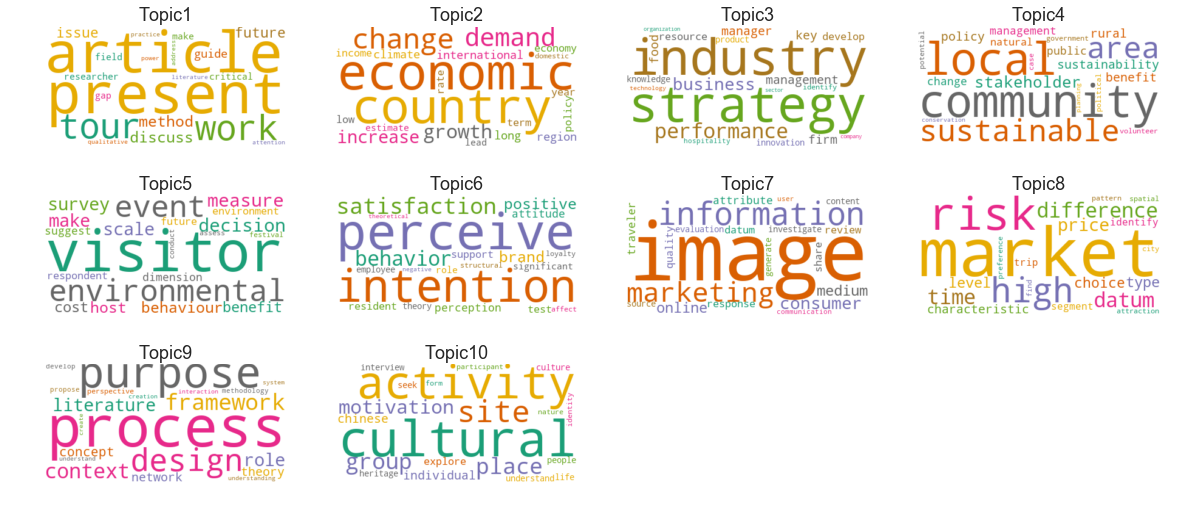

In [40]:
# create wordclouds for each topic
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize']=[20,15]

# create sub-plots for each topic
for i in range(10):
    wc.generate(text=topics_df['Terms per Topic'][i])
    
    plt.subplot(5,4, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(topics_df.index[i])

plt.show()

<h2> Visualization with pyLDAvis</h2>

In [41]:
# you need to convert LdaMallet model to a gensim model.
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [42]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [43]:
# Then, we need to transform the topic model distributions and related corpus data into the data structures needed for the visualization
import pyLDAvis.gensim as gensimvis

vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)

pyLDAvis.display(vis_data)

C:\Users\sara\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [44]:
# You can hover over bubbles and get the most relevant 30 words on the right

<h2> Dominant Topics for Each Document</h2>

In [45]:
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Title'] = df.Title
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,Title,Dominant Topic,Contribution %,Topic Terms
0,Title 1,3,28.00,"industry, strategy, performance, business, management, manager, firm, key, food, resource, develop, knowledge, product, innovation, identify, hospitality, technology, organization, sector, company"
1,Title 2,10,17.76,"cultural, activity, site, group, place, motivation, individual, chinese, explore, heritage, people, understand, culture, seek, life, interview, participant, identity, nature, form"
2,Title 3,7,19.57,"image, information, marketing, consumer, online, medium, attribute, traveler, response, review, datum, quality, share, investigate, evaluation, content, source, generate, communication, user"
3,Title 4,9,35.68,"process, purpose, design, framework, context, literature, role, concept, theory, network, perspective, methodology, propose, develop, understanding, create, interaction, creation, system, understand"
4,Title 5,9,25.14,"process, purpose, design, framework, context, literature, role, concept, theory, network, perspective, methodology, propose, develop, understanding, create, interaction, creation, system, understand"


In [46]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

,Title,Dominant Topic,Contribution %,Topic Terms
0,Title 1017,1,39.89,"article, present, work, tour, discuss, method, future, issue, guide, researcher, make, gap, field, critical, qualitative, practice, literature, power, attention, address"
1,Title 865,2,56.05,"economic, country, change, demand, growth, increase, international, climate, long, region, economy, year, policy, low, term, income, rate, estimate, lead, domestic"
2,Title 1135,3,41.79,"industry, strategy, performance, business, management, manager, firm, key, food, resource, develop, knowledge, product, innovation, identify, hospitality, technology, organization, sector, company"
3,Title 4143,4,43.80,"community, local, sustainable, area, stakeholder, sustainability, policy, rural, benefit, management, change, public, natural, government, case, potential, volunteer, political, conservation, planning"
4,Title 3310,5,42.01,"visitor, environmental, event, decision, measure, survey, make, scale, behaviour, host, benefit, cost, suggest, dimension, respondent, environment, future, festival, conduct, assess"
5,Title 3195,6,51.25,"perceive, intention, satisfaction, behavior, positive, brand, perception, attitude, resident, test, support, significant, role, employee, theory, loyalty, affect, structural, negative, theoretical"
6,Title 4750,7,42.10,"image, information, marketing, consumer, online, medium, attribute, traveler, response, review, datum, quality, share, investigate, evaluation, content, source, generate, communication, user"
7,Title 4897,8,39.20,"market, risk, high, difference, datum, time, price, type, level, choice, characteristic, identify, segment, trip, pattern, attraction, preference, city, find, spatial"
8,Title 85,9,50.83,"process, purpose, design, framework, context, literature, role, concept, theory, network, perspective, methodology, propose, develop, understanding, create, interaction, creation, system, understand"
9,Title 2315,10,43.68,"cultural, activity, site, group, place, motivation, individual, chinese, explore, heritage, people, understand, culture, seek, life, interview, participant, identity, nature, form"


In [47]:
# topic distribution for the first document
pprint(tm_results[0])

[(0, 0.08),
 (1, 0.08571428571428572),
 (2, 0.28),
 (3, 0.10031746031746032),
 (4, 0.047619047619047616),
 (5, 0.03301587301587302),
 (6, 0.11174603174603175),
 (7, 0.0838095238095238),
 (8, 0.14476190476190476),
 (9, 0.03301587301587302)]


In [59]:
# transform tm_resultsto a dataframe to analyze it easily
df_weights = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_weights.columns=['Topic'+str(i) for i in range(1,11)]


In [60]:
df_weights.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,0.080000,0.085714,0.280000,0.100317,0.047619,0.033016,0.111746,0.083810,0.144762,0.033016
1,0.078670,0.039740,0.137064,0.045418,0.079481,0.137064,0.104623,0.042174,0.158151,0.177616
2,0.101328,0.090846,0.058700,0.039133,0.055206,0.159329,0.195667,0.106918,0.140461,0.052411
3,0.117411,0.045246,0.105384,0.045246,0.119129,0.054410,0.036082,0.057847,0.356816,0.062428
4,0.104807,0.052009,0.156028,0.055950,0.079590,0.042553,0.095351,0.086682,0.251379,0.075650


In [61]:
# add “Year” column and get the average of yearly topic weights
df_weights['Year'] = df.Year
df_weights.groupby('Year').mean()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
Year,,,,,,,,,,
1981,0.100168,0.100337,0.094960,0.095866,0.097869,0.107799,0.098290,0.099176,0.103600,0.101935
1982,0.097031,0.105594,0.097826,0.099358,0.094718,0.107951,0.096523,0.101915,0.098711,0.100372
1983,0.099380,0.104044,0.098364,0.100567,0.095444,0.101922,0.099904,0.103192,0.100665,0.096517
1984,0.101437,0.098898,0.099058,0.102715,0.096430,0.102572,0.096741,0.099646,0.103893,0.098609
1985,0.098531,0.100487,0.095208,0.099658,0.098802,0.105135,0.103214,0.099900,0.099235,0.099830
1986,0.101175,0.101005,0.098314,0.102161,0.095246,0.105957,0.097209,0.100099,0.099195,0.099638
1987,0.103381,0.101786,0.102770,0.103127,0.097853,0.097197,0.096185,0.097786,0.101115,0.098800
1988,0.102377,0.100944,0.096153,0.099396,0.097945,0.103229,0.094906,0.097132,0.103602,0.104316
1989,0.100518,0.103842,0.098955,0.100045,0.098393,0.104589,0.100855,0.097299,0.097718,0.097787


In [62]:
# As you can see the yearly average weights of topics are so close. 
#  get which topic is dominant in each document
df_weights['Dominated']= df_weights.drop('Year', axis=1).idxmax(axis=1)
df_weights.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Year,Dominated
0,0.080000,0.085714,0.280000,0.100317,0.047619,0.033016,0.111746,0.083810,0.144762,0.033016,1988,Topic3
1,0.078670,0.039740,0.137064,0.045418,0.079481,0.137064,0.104623,0.042174,0.158151,0.177616,1982,Topic10
2,0.101328,0.090846,0.058700,0.039133,0.055206,0.159329,0.195667,0.106918,0.140461,0.052411,1981,Topic7
3,0.117411,0.045246,0.105384,0.045246,0.119129,0.054410,0.036082,0.057847,0.356816,0.062428,1990,Topic9
4,0.104807,0.052009,0.156028,0.055950,0.079590,0.042553,0.095351,0.086682,0.251379,0.075650,1990,Topic9


In [65]:
# get the percentage of dominant topics in a given year by grouping the dataframe by ‘Year’ column
# we get a multi-index pandas Series. To convert it to a dataframe where rows are “years” and columns are “topics”, 
# we need to chain unstack()
df_dominance = df_weights.groupby('Year')['Dominated'].value_counts(normalize=True).unstack()
df_dominance

Dominated,Topic1,Topic10,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
Year,,,,,,,,,,
1981,0.096491,0.115789,0.115789,0.070175,0.117544,0.082456,0.147368,0.098246,0.082456,0.073684
1982,0.076233,0.103139,0.144993,0.082212,0.112108,0.064275,0.161435,0.088191,0.088191,0.079223
1983,0.075125,0.083472,0.128548,0.088481,0.116861,0.070117,0.135225,0.110184,0.116861,0.075125
1984,0.094502,0.104811,0.109966,0.080756,0.132302,0.084192,0.130584,0.091065,0.092784,0.079038
1985,0.099668,0.102990,0.121262,0.074751,0.111296,0.073090,0.142857,0.121262,0.083056,0.069767
1986,0.080420,0.108392,0.115385,0.080420,0.125874,0.080420,0.152098,0.089161,0.090909,0.076923
1987,0.115254,0.100000,0.123729,0.111864,0.125424,0.076271,0.108475,0.091525,0.081356,0.066102
1988,0.111492,0.114923,0.126930,0.072041,0.108062,0.075472,0.133791,0.090909,0.085763,0.080617
1989,0.079935,0.096248,0.135400,0.094617,0.122349,0.070147,0.137031,0.130506,0.073409,0.060359


In [99]:
# We can also get trends for each “journal”. 
df_weights['Journal'] = df.Journal
df_journals = df_weights.groupby(['Journal', 'Year'])['Dominated'].value_counts(normalize=True).unstack()
df_journals.head(15)

Dominated          Topic1   Topic10    Topic2    Topic3    Topic4    Topic5  \
Journal    Year                                                               
Journal 1  1981  0.029412  0.147059  0.205882  0.058824  0.117647  0.176471   
           1982  0.058824  0.205882  0.088235  0.176471  0.088235  0.029412   
           1983  0.041667  0.208333  0.166667  0.083333 NaN        0.125000   
           1984  0.206897  0.172414  0.068966  0.137931  0.068966 NaN         
           1985  0.073171  0.121951  0.146341  0.073171  0.073171  0.121951   
           1986  0.037037  0.074074  0.111111  0.148148  0.185185  0.037037   
           1987  0.173913  0.130435  0.173913  0.043478  0.130435  0.043478   
           1988  0.176471 NaN        0.058824  0.147059  0.058824  0.088235   
           1989  0.076923  0.153846  0.230769  0.076923  0.038462  0.038462   
           1990  0.176471  0.029412  0.147059  0.147059  0.058824  0.029412   
Journal 10 1981  0.083333  0.208333  0.125000 NaN        0.083333  0.041667   
           1982  0.108108  0.081081  0.216216  0.108108  0.162162  0.027027   
           1983  0.133333  0.033333  0.100000  0.166667  0.033333  0.100000   
           1984  0.073171  0.146341  0.146341  0.170732  0.048780  0.146341   
           1985  0.057143  0.114286  0.171429  0.085714  0.114286  0.085714   

Dominated          Topic6    Topic7    Topic8    Topic9  
Journal    Year                                          
Journal 1  1981  0.088235  0.029412  0.058824  0.088235  
           1982  0.117647  0.117647  0.029412  0.088235  
           1983  0.125000  0.083333  0.125000  0.041667  
           1984  0.137931  0.068966  0.034483  0.103448  
           1985  0.073171  0.097561  0.121951  0.097561  
           1986  0.111111  0.074074  0.111111  0.111111  
           1987  0.173913  0.043478  0.086957 NaN        
           1988  0.117647  0.088235  0.235294  0.029412  
           1989  0.192308  0.115385  0.076923 NaN        
           1990  0.088235  0.058824  0.264706 NaN        
Journal 10 1981  0.125000  0.041667  0.166667  0.125000  
           1982  0.081081  0.027027  0.135135  0.054054  
           1983  0.133333  0.066667  0.166667  0.066667  
           1984  0.024390  0.073171  0.097561  0.073171  
           1985  0.142857  0.028571  0.057143  0.142857

<h3> plot topic distributions over time for each journal</h3>

In [100]:
df_journals.reset_index(inplace=True)
df_journals.head()

Dominated,Journal,Year,Topic1,Topic10,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,Journal 1,1981,0.029412,0.147059,0.205882,0.058824,0.117647,0.176471,0.088235,0.029412,0.058824,0.088235
1,Journal 1,1982,0.058824,0.205882,0.088235,0.176471,0.088235,0.029412,0.117647,0.117647,0.029412,0.088235
2,Journal 1,1983,0.041667,0.208333,0.166667,0.083333,NaN,0.125000,0.125000,0.083333,0.125000,0.041667
3,Journal 1,1984,0.206897,0.172414,0.068966,0.137931,0.068966,NaN,0.137931,0.068966,0.034483,0.103448
4,Journal 1,1985,0.073171,0.121951,0.146341,0.073171,0.073171,0.121951,0.073171,0.097561,0.121951,0.097561


In [101]:
# create multiindex dataframe
df_journals.set_index(['Journal', 'Year'], inplace=True)
#df_journals.drop(['index'], axis=1, inplace=True)
df_journals.head()

Dominated         Topic1   Topic10    Topic2    Topic3    Topic4    Topic5  \
Journal   Year                                                               
Journal 1 1981  0.029412  0.147059  0.205882  0.058824  0.117647  0.176471   
          1982  0.058824  0.205882  0.088235  0.176471  0.088235  0.029412   
          1983  0.041667  0.208333  0.166667  0.083333 NaN        0.125000   
          1984  0.206897  0.172414  0.068966  0.137931  0.068966 NaN         
          1985  0.073171  0.121951  0.146341  0.073171  0.073171  0.121951   

Dominated         Topic6    Topic7    Topic8    Topic9  
Journal   Year                                          
Journal 1 1981  0.088235  0.029412  0.058824  0.088235  
          1982  0.117647  0.117647  0.029412  0.088235  
          1983  0.125000  0.083333  0.125000  0.041667  
          1984  0.137931  0.068966  0.034483  0.103448  
          1985  0.073171  0.097561  0.121951  0.097561

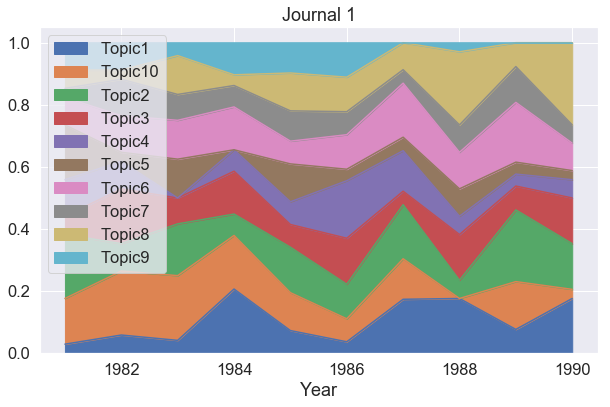

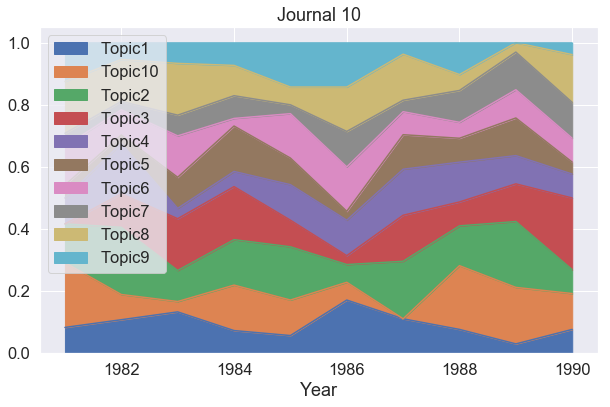

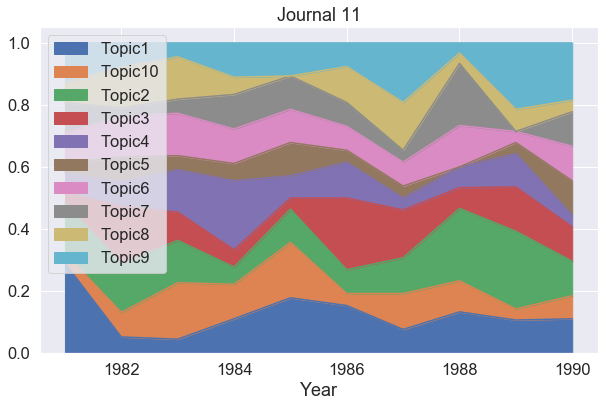

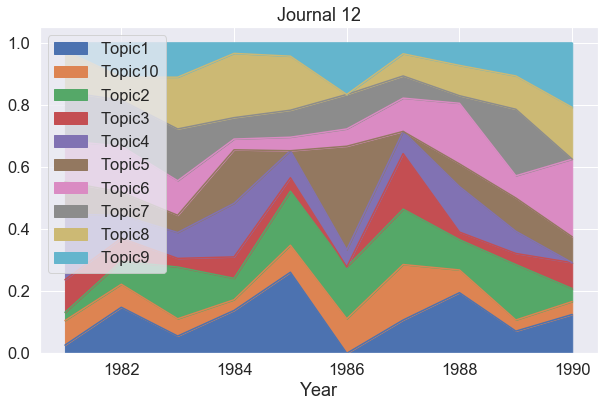

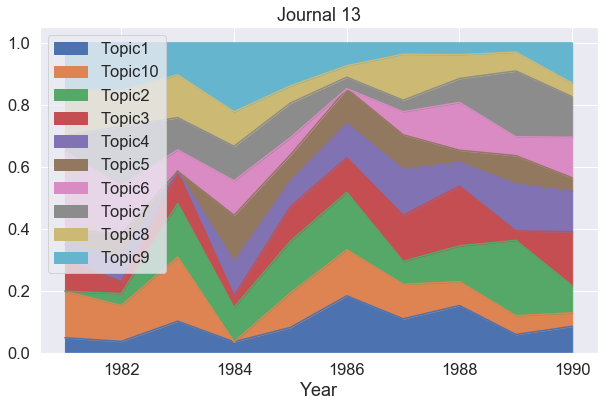

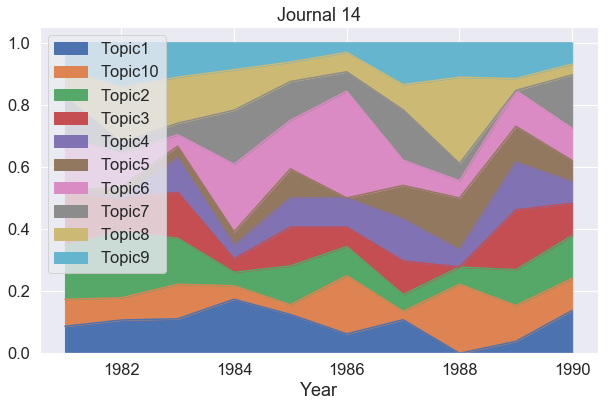

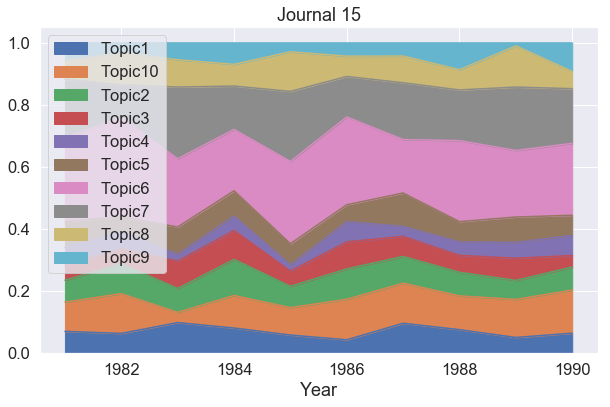

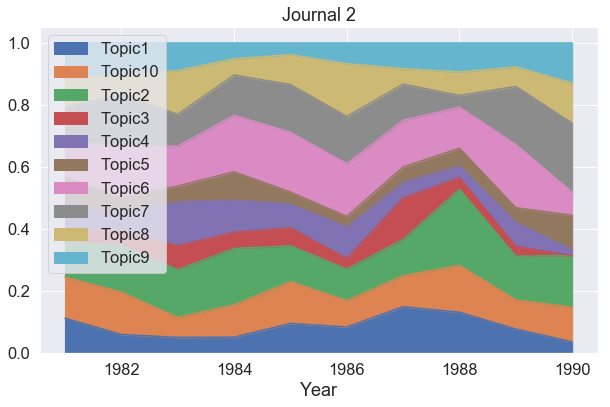

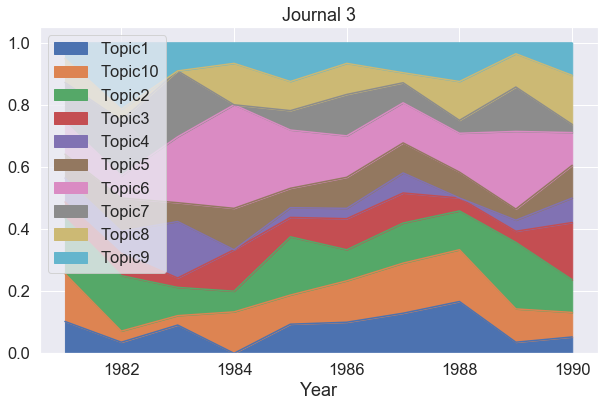

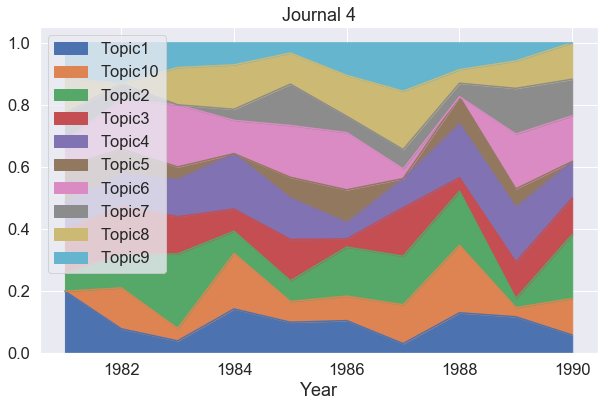

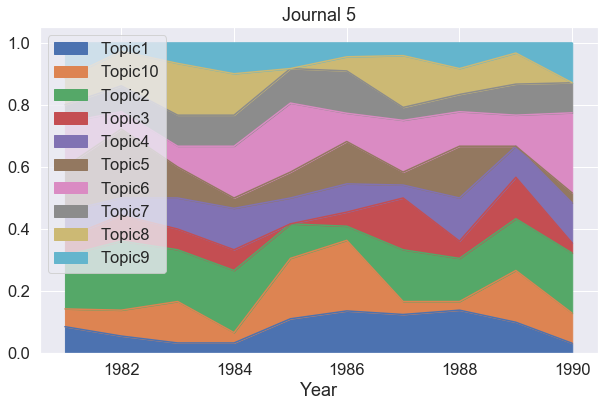

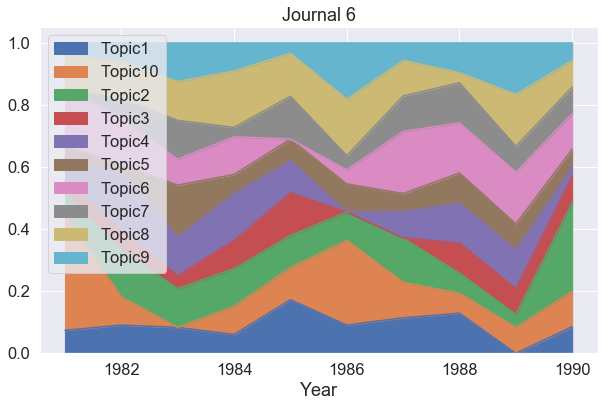

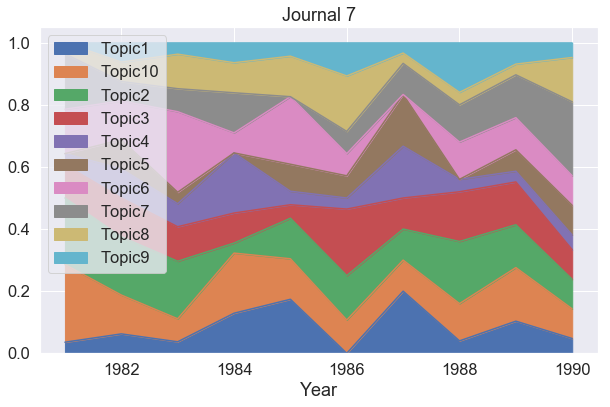

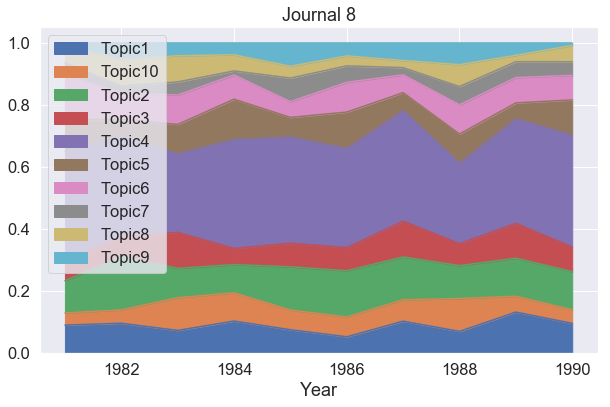

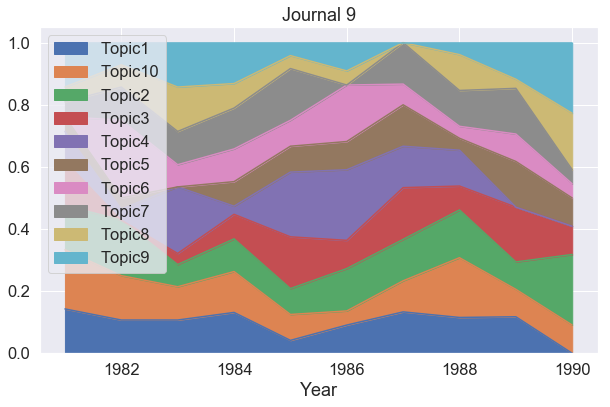

In [102]:
# set the figure size
plt.rcParams['figure.figsize'] = [10, 6]

# loop over each journal
for j in df_journals.index.levels[0]:
  
  # get cross-section and plot
  df_journals.xs(j, level=0).plot.area()
  
  plt.title(j)
  plt.legend(loc='upper left')

plt.show()